# ImageDataGenerator
(```tensorflow.keras.preprocessing.image.ImageDataGenerator```)

See example below to know how to use.

(751, 750, 3)


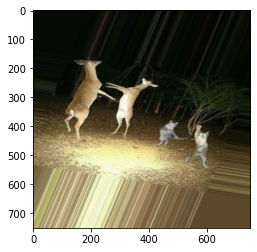

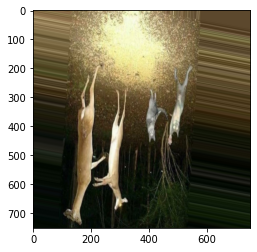

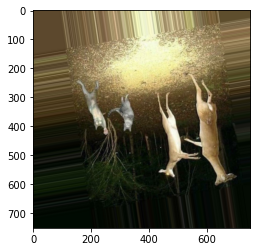

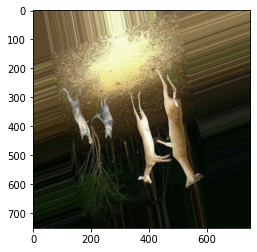

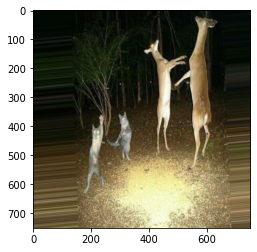

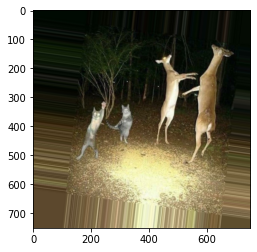

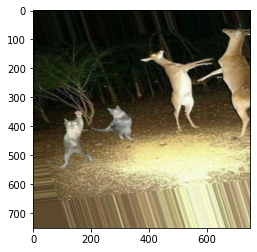

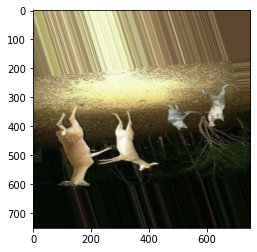

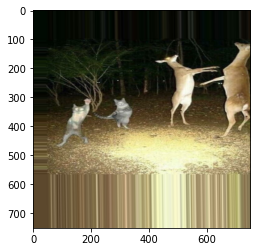

In [ ]:
import tensorflow as tf
import numpy as np
img = tf.keras.preprocessing.image.load_img('party.jpg') # load image to preprocess
x = tf.keras.preprocessing.image.img_to_array(img) # convert image to numpy array
shape = x.shape # save shape temporarily
print(shape)

x = x.reshape((1,) + shape) # Dimension Extension to contain number of image.

data_aug_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,         # 1./255 rescaler for normalizing: pixel value between 0.0 ~ 1.0
    rotation_range=15,      # Maximum allowed rotation degree is 15 degree
    width_shift_range=0.1,  # Maximum allowed width shift is 0.1
    height_shift_range=0.1, # Maximum allowed height shift is 0.1
    shear_range=0.5,        # Maximum allowed shear is 0.5; (shear: distorted along an axis)
    zoom_range=[0.8, 2.0],  # Maximum allowed zoom magnification
    horizontal_flip=True,   # Horizontal flipping is allowed
    vertical_flip=True,     # Vertical flipping is allowed
    fill_mode='nearest'
)

imageGen = data_aug_gen.flow(x, batch_size=1)

import matplotlib.pyplot as plt
imgCnt = 0
for img in imageGen:
    imgCnt += 1
    if imgCnt < 10:
        plt.imshow(img.reshape(shape))
        plt.show()
    else:
        break

# Implement ```ImageDataGenerator```


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import datasets 
from tensorflow.keras.utils import to_categorical

# load CIFAR10 Dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

print("Length of train set:", len(Y_train))
print("Shape of x_train:", x_train.shape[1:])

Length of train set: 50000
Shape of x_train: (32, 32, 3)


In [3]:
img_rows, img_cols, channel = x_train.shape[1:]

# Unifying image size (reshape X_train, X_test)
X_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channel)
X_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channel)
input_shape = (img_rows, img_cols, channel)

# Normalize pixel value in image
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Label is already one-hot encoded
print(Y_train[0])
num_classes = 10
batch_size = 32
print(input_shape)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(32, 32, 3)


In [4]:
x = layers.Input(shape=input_shape,  name='input')
h = layers.BatchNormalization()(x)
h = layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1.E-04), name='conv1')(h)
h = layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(1.E-04), name='conv2')(h)
h = layers.BatchNormalization()(h)
h = layers.MaxPooling2D(pool_size=(2, 2), name='pool1')(h)
h = layers.Dropout(0.2)(h)

h = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                  kernel_regularizer=tf.keras.regularizers.l2(1.E-04), name='conv3')(h)
h = layers.BatchNormalization()(h)
h = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                  kernel_regularizer=tf.keras.regularizers.l2(1.E-04), name='conv4')(h)
h = layers.BatchNormalization()(h)
h = layers.MaxPooling2D(pool_size=(2, 2), name='pool2')(h)
h = layers.Dropout(0.3)(h)
h = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                  kernel_regularizer=tf.keras.regularizers.l2(1.E-04), name='conv5')(h)
h = layers.BatchNormalization()(h)
h = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                  kernel_regularizer=tf.keras.regularizers.l2(1.E-04), name='conv6')(h)
h = layers.BatchNormalization()(h)
h = layers.MaxPooling2D(pool_size=(2, 2), name='pool3')(h)
h = layers.Dropout(0.4)(h)

h = layers.Flatten()(h)
y = layers.Dense(num_classes, activation='softmax', name='output')(h)


model = models.Model(x, y)
print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv1 (Conv2D)               (None, 30, 30, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0     

In [5]:
def lr_schedule(epoch): # Learning Rate Scheduler
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003
    return lrate

# Pre-processing using ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)
print(x_train.shape[0] // batch_size)

1562


In [6]:
# 'steps_per_epoch' sets how many batch runs on one epoch.
# Maximum is (x_train.shape[0] // batch_size)
epochs = 125
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, verbose=2,
                    validation_data=(X_test, Y_test), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])


Epoch 1/125
1562/1562 - 32s - loss: 1.8251 - accuracy: 0.4149 - val_loss: 1.2212 - val_accuracy: 0.5787
Epoch 2/125
1562/1562 - 28s - loss: 1.2290 - accuracy: 0.5799 - val_loss: 1.0340 - val_accuracy: 0.6571
Epoch 3/125
1562/1562 - 29s - loss: 1.0630 - accuracy: 0.6471 - val_loss: 0.9821 - val_accuracy: 0.6777
Epoch 4/125
1562/1562 - 29s - loss: 0.9948 - accuracy: 0.6815 - val_loss: 0.9699 - val_accuracy: 0.7039
Epoch 5/125
1562/1562 - 28s - loss: 0.9479 - accuracy: 0.7026 - val_loss: 0.9987 - val_accuracy: 0.6975
Epoch 6/125
1562/1562 - 29s - loss: 0.9274 - accuracy: 0.7159 - val_loss: 0.8059 - val_accuracy: 0.7691
Epoch 7/125
1562/1562 - 29s - loss: 0.9046 - accuracy: 0.7278 - val_loss: 0.8875 - val_accuracy: 0.7428
Epoch 8/125
1562/1562 - 28s - loss: 0.8919 - accuracy: 0.7382 - val_loss: 0.7797 - val_accuracy: 0.7810
Epoch 9/125
1562/1562 - 29s - loss: 0.8722 - accuracy: 0.7464 - val_loss: 0.7484 - val_accuracy: 0.7976
Epoch 10/125
1562/1562 - 29s - loss: 0.8661 - accuracy: 0.7520 -

In [7]:
score = model.evaluate(X_test, Y_test)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save('cifar_88.h5')

313/313 [==============================] - 1s 4ms/step - loss: 0.5681 - accuracy: 0.8621

Test loss: 0.5680919289588928
Test accuracy: 0.8621000051498413
